In [1]:
import os

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch import optim
from torch import nn

from torchmetrics import Accuracy
import torchmetrics
from torchkeras import KerasModel

from matplotlib import pyplot as plt
from scipy import signal

from entity import *
from utils import deg_pol2cart, analysis

## TODO

- GAN补充细节, 补充信号波形先验信息
- 由输入阵列信号估计初相位 (得分析下实际设备信号特征), 从而应用三元阵时延估计法

## 数据准备

### 数据生成

由于预测是实时的，因此GCC等计算不能在数据集中进行，应作为模型的一层。此处的数据就是原始信号。

In [4]:
c = 1500
fs = 8 * 37500
dist_max = 0.08*3
maxlag = int(np.ceil(dist_max / c * fs))  # 当前采样频率下最大滞后量

dataset_path = 'dataset/fc_37500-fs_factor_8-d_0.08-K_2/'
train_path = f'{dataset_path}/train'
val_path = f'{dataset_path}/val'

In [3]:
# 清除损坏样本文件
# for path in train_path, val_path:
#     files = os.listdir(path)
#     for file in files:
#         try:
#             np.load(f'{path}/{file}')
#         except:
#             print(file)
#             os.remove(f'{path}/{file}')

In [4]:
# !python sim_data_generator.py --sample_interval 1 --d 0.08 --K 2 --fc 1000 --c 340 --fs_factor 16

进行加窗互相关，每个样本由$(C, L)$形状转为$(C, L // W, 2\tau +1)$。W暂时选择1s的采样点数

生成的是3通道，5s的数据，从15度到165度，采样率37500x4，共5x151个样本。

In [5]:
class SigArrDataSet(Dataset):
    def __init__(self, folder_path):
        # folder_path下所有文件的列表
        self.filepaths = [f'{folder_path}/{filename}' for filename in os.listdir(folder_path)]

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        arr_dict = np.load(self.filepaths[idx])
        data = arr_dict['snapshots']
        angles = arr_dict['angles']
        data = torch.from_numpy(data).float()
        # 将角度转为单位向量, 增大标签维度, 减小标签差异
        theta = torch.deg2rad(torch.from_numpy(angles).float())
        label = torch.stack([torch.cos(theta), torch.sin(theta)]).squeeze()
        return data, label

### DataLoader构造

In [6]:
def create_dataloaders(batch_size=200):
    ds_train = SigArrDataSet(train_path)
    ds_val = SigArrDataSet(val_path)

    # 取样时有打乱
    dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=1, drop_last=False)
    dl_val = DataLoader(ds_val, batch_size=batch_size, shuffle=True, num_workers=1, drop_last=False)
    return dl_train, dl_val

dl_train, dl_val = create_dataloaders()

## 模型定义

In [7]:
# 自定义一维因果卷积层
class CausalConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1):
        super().__init__()
        self.padding = (kernel_size - 1) * dilation
        self.conv1d = nn.Conv1d(in_channels, out_channels, kernel_size, padding=self.padding, dilation=dilation)

    def forward(self, x):
        return self.conv1d(x)[:, :, :x.size(2)]


# 自定义一维因果CNN层
# NOTE: 由于是CW信号，在有短脉冲的情况下归一化幅度会进一步压平相关峰，因此不使用GCC
class CausalCnn1d(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        in_conv_channels = 1024
        mid_conv_channels = 512
        out_conv_channels = 128
        kernel_size = 5
        mid_depth = 4

        self.in_layers = nn.Sequential(
            CausalConv1d(in_channels, in_conv_channels, kernel_size),
            nn.PReLU(in_conv_channels),
        )

        self.mid_layers = nn.ModuleList([
            CausalConv1d(in_conv_channels, mid_conv_channels, kernel_size),
            nn.PReLU(mid_conv_channels),
        ])
        self.mid_layers += nn.ModuleList([
            CausalConv1d(mid_conv_channels, mid_conv_channels, kernel_size),
            nn.PReLU(mid_conv_channels),
        ] * (mid_depth - 1))

        self.out_layers = nn.Sequential(
            CausalConv1d(mid_conv_channels, out_conv_channels, kernel_size, dilation=2),
            nn.PReLU(),
            CausalConv1d(out_conv_channels, 2, kernel_size, dilation=2)  # 仅识别平面方位角, 以单位向量形式输出，因此输出通道数为2
        )

    def forward(self, x):
        x = self.in_layers(x)
        for layer in self.mid_layers:
            x = layer(x)
        x = self.out_layers(x)  # shape: (-1, 2, slices)
        x = torch.tanh(x)  # 应当输出的是单位向量, 因此将输出归一化到(-1，1), 简单约束下# FIXME: 改用归一化层
        return x

class Xcorr(nn.Module):
    def __init__(self, maxlag):
        super().__init__()
        self.maxlag = maxlag

    def forward(self, x):
        """进行加窗互相关，窗口暂时设为整个序列长度，输入为（batch_size, channels, seq_len），输出为（batch_size, channels*（2*maxlag+1），1）
        """
        batch_size, channels, seq_len, slices = x.size()
        xcorr_slices = torch.empty(batch_size, channels * (2 * self.maxlag + 1), slices, device=x.device)
        for i in range(slices):
            x_slice = x[:, :, :, i]
            # conv1d本身不支持一批输入使用不同卷积内核，因此调整形状，将批量数调整到通道数维度，并行计算
            y = x_slice[:, [1, 2, 0], :].reshape((batch_size * channels, 1, seq_len))
            x_slice = x_slice.reshape(1, batch_size * channels, seq_len)
            # 以padding设置互相关计算的最大时延限制，减少计算量
            xcorr = nn.functional.conv1d(x_slice, y, groups=batch_size * channels, padding=self.maxlag)  # shape: (1, batch_size * channels, 2*maxlag+1)
            xcorr = xcorr.reshape(batch_size, channels, 2 * self.maxlag + 1)
            max_vals, _ = torch.max(xcorr, dim=2, keepdim=True)
            xcorr = xcorr / max_vals  # 归一化时每组互相关分别归一化
            xcorr = xcorr.reshape(batch_size, channels * (2 * self.maxlag + 1))  # 认为通道数为最大时延限制内各阵元两两互相关值数量
            xcorr_slices[:, :, i] = xcorr
        return xcorr_slices

class CausalCnn1d_from_Xcorr(nn.Module):
    def __init__(self, maxlag, signal_channels, device:str | None = None) -> None:
        super().__init__()
        self.xcorr = Xcorr(maxlag)
        self.cnn = CausalCnn1d(signal_channels * (2 * maxlag + 1))

    def forward(self, x):
        x = self.xcorr(x)
        return self.cnn(x)

In [33]:
# from torchkeras import summary
# summary(CausalCnn1d_from_Xcorr(maxlag, 3), input_data=list(dl_train)[0][0])

--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
Xcorr-1                                 [-1, 81, 20]                    0
Conv1d-2                              [-1, 1024, 24]              415,744
PReLU-3                               [-1, 1024, 20]                1,024
Conv1d-4                               [-1, 512, 24]            2,621,952
PReLU-5                                [-1, 512, 20]                  512
Conv1d-6                               [-1, 512, 24]            1,311,232
PReLU-7                                [-1, 512, 20]                  512
Conv1d-8                               [-1, 512, 24]            1,311,232
PReLU-9                                [-1, 512, 20]                  512
Conv1d-10                              [-1, 512, 24]            1,311,232
PReLU-11                               [-1, 512, 20]                  512
Conv1d-12                            

'--------------------------------------------------------------------------\nLayer (type)                            Output Shape              Param #\n==========================================================================\nXcorr-1                                 [-1, 81, 20]                    0\nConv1d-2                              [-1, 1024, 24]              415,744\nPReLU-3                               [-1, 1024, 20]                1,024\nConv1d-4                               [-1, 512, 24]            2,621,952\nPReLU-5                                [-1, 512, 20]                  512\nConv1d-6                               [-1, 512, 24]            1,311,232\nPReLU-7                                [-1, 512, 20]                  512\nConv1d-8                               [-1, 512, 24]            1,311,232\nPReLU-9                                [-1, 512, 20]                  512\nConv1d-10                              [-1, 512, 24]            1,311,232\nPReLU-11              

## 模型训练

/home/leo/.pyenv/versions/torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<<<<<< ⚡️ cuda is used >>>>>>


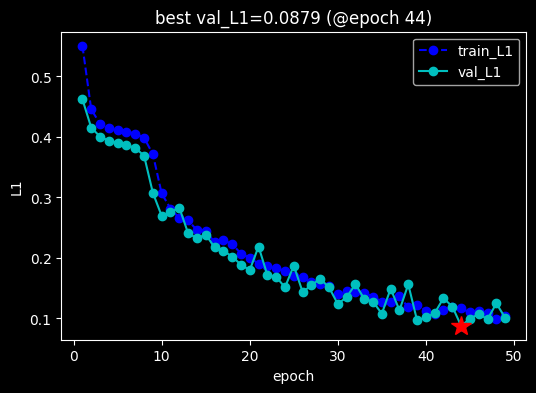

<<<<<< val_L1 without improvement in 5 epoch,early stopping >>>>>> 



,epoch,train_loss,train_L1,lr,val_loss,val_L1
0,1,0.550821,0.550821,0.1,0.462209,0.462209
1,2,0.445553,0.445553,0.1,0.415508,0.415507
2,3,0.421796,0.421796,0.1,0.400546,0.400546
3,4,0.414592,0.414592,0.1,0.393813,0.393813
4,5,0.411372,0.411372,0.1,0.389968,0.389968
5,6,0.408916,0.408916,0.1,0.386639,0.386639
6,7,0.405696,0.405696,0.1,0.381765,0.381765
7,8,0.398565,0.398565,0.1,0.369093,0.369093
8,9,0.371575,0.371575,0.1,0.307582,0.307582
9,10,0.306514,0.306514,0.1,0.269576,0.269576


In [9]:
def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.normal_(m.weight)
        m.bias.data.fill_(0.0)

net = CausalCnn1d_from_Xcorr(maxlag, 3)  # 3个通道
net.apply(init_weights)  # 初始化权重为全零


optimizer=optim.SGD(net.parameters(), lr=1e-1)  # TODO: 试试Adam
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

model = KerasModel(
    net,
    # loss_fn=loss_with_regulation,
    loss_fn=nn.L1Loss(),
    # loss_fn=nn.MSELoss(),
    metrics_dict={'L1': torchmetrics.MeanAbsoluteError()},#, 'mse': torchmetrics.MeanSquaredError()},
    optimizer=optimizer,
    lr_scheduler=lr_scheduler
)

model.fit(
    dl_train,
    dl_val,
    epochs=50,
    ckpt_path='exp/checkpoint',
    patience=5,
    monitor='val_L1',
    mode='min',
)

## 模型评估

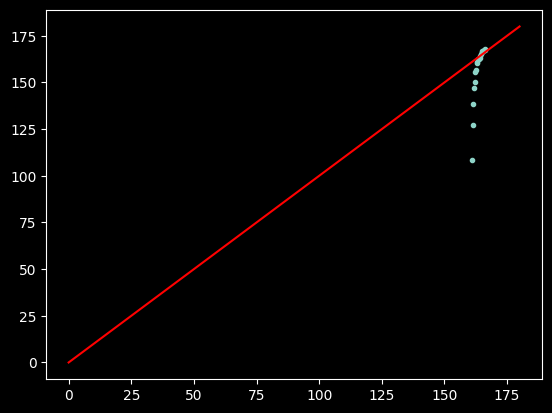

In [42]:
device = torch.device('cuda')
net = model.net
net.eval()

net.to(device)
data, label = SigArrDataSet(val_path)[np.random.randint(0, 400)]
data = data.to(device)
output = net(data.unsqueeze(0))
predicted = output.detach().cpu().numpy()
label = label.cpu().numpy()
# predicted = (predicted + 1) * 90
# label = (label + 1) * 90
predicted_angles = np.rad2deg(np.arctan2(predicted[0, 1, :], predicted[0, 0, :]))
label_angles = np.rad2deg(np.arctan2(label[1], label[0]))
plt.plot(label_angles, predicted_angles, '.')
# plt.plot([np.min(np.stack((label_angles, predicted_angles))), np.max(np.stack((label_angles, predicted_angles)))], [np.min(np.stack((label_angles, predicted_angles))), np.max(np.stack((label_angles, predicted_angles)))], 'r')
plt.plot([0, 180], [0, 180], 'r')

In [11]:
predicted.shape, label.shape

((1, 2, 20), (2, 20))

## 预测